In [0]:
test=False

mounted = False
output_file = "output.csv"
try:
    import google.colab
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False

def mount_drive():
    global mounted
    drive.mount("/content/drive", force_remount=True)
    mounted = True

def open_dataset(filepath):
    if IN_COLAB:
        global output_file
        output_file = "/content/drive/My Drive/CE101/output.csv"
        filepath = '/content/drive/My Drive/CE101/{}'.format(filepath)
        if not mounted:
            mount_drive()
    data = pd.read_csv(filepath)
    return data

def scatter(y, x):
    fig, ax = plt.subplots()
    ax.scatter(x = train_dataset[x], y = train_dataset[y])
    plt.ylabel(y)
    plt.xlabel(x)
    plt.show()
    
def boxplot(x,y="SalePrice"):
    sns.boxplot(x=train_dataset[x].sort_values(), y=train_dataset[y])
    plt.show()



def distribution(column_name):
  #Check to see if the data is now normally skwewed
  sns.distplot(combined_data[column_name], fit=norm);

  plt.ylabel('Frequency')
  plt.xlabel( column_name + ' distribution')
  fig = plt.figure()
  res = stats.probplot(combined_data[column_name], plot=plt)
  plt.show()

def missing(df):
  total = df.isnull().sum().sort_values(ascending = False) [df.isnull().sum().sort_values(ascending = False) != 0]
  percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  return missing_data



import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy import stats

from scipy.stats import norm, skew
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import xgboost as xgb


import warnings
warnings.filterwarnings('ignore')



pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

The below code loads both of the data files provided using the Pandas method pd.read_csv

This formats the data into the dataframes datastructure which allows for easy manipulation of data.

Note: If running this file inside of Google COLAB, ensure that you have the test.csv and train.csv files uploaded to your Google Drive, in a folder called "CE101"

In [0]:
train_dataset = open_dataset("train.csv")
test_dataset = open_dataset("test.csv")

Mounted at /content/drive


# Exploratory Data Analysis

to begin to understand the problem that needs to be solved, it is important to explore and understand the data. The first variable that needs to be identified is the target variable, which is the variable that the machine leaning model will be predicting.


# The sale price: 

In [0]:
train_dataset['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The description of the sales price column lists some important facts, such as the mininum price being above 0, which is what you'd expect.

Ploting the prices against frequencies, we see that the data distributes roughly in a normal distribution with the peak skewed to the left, which means that the data is not perfectly symetrical, with the most frequent price being in the first fourth of the SalePrice distribution axis. The data's tendency to a normal distribution is further confirmed by a probability plot of the data, which also follows a trend of a slanted line. However, the data does not distribute perfectly and will need tweeking.

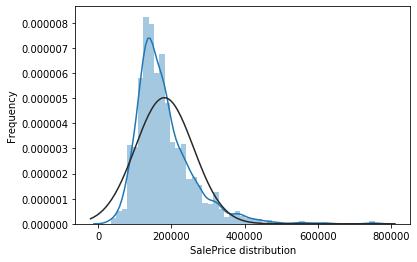

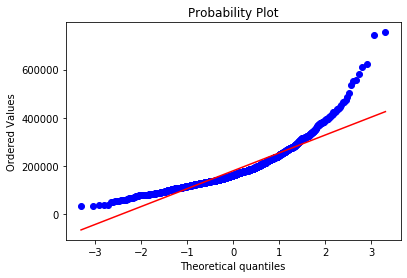

In [0]:
sns.distplot(train_dataset['SalePrice'], fit=norm);

#(mu, sigma) = norm.fit(train_dataset['SalePrice'])

#plt.legend(['Norm dist. ($\mu=$ {:2f} and $\sigma=$ {:2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.xlabel('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_dataset['SalePrice'], plot=plt)
plt.show()

# Types of Variables

Next, an important step is to categorise the rest of the variables into their different types, numerical or categorical. Using the data description file, they can be catagorised as so:
 
# Catagorical Data: 
MSSubClass
MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
OverallQual
OverallCond
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


Catagorical data can then be split into two different types: catagories which have an order, and catagories which do not have a natural order

catagories with an order:

Catagories without order:


# Numerical Data:
LotFrontage
LotArea
YearBuilt
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
Bedroom
KitchenAbvGr
TotRmsAvvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold

# Variable Correlation
Firstly we may look at the numerical data, which is correlated the most with our target variable:

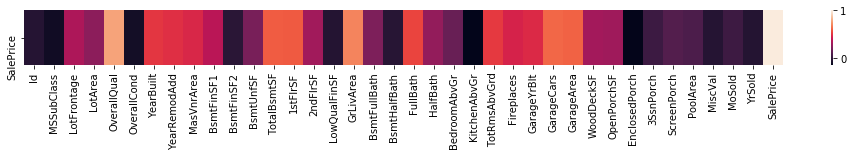

In [0]:
#code in this block: retrieved and modified from https://www.kaggle.com/amiiiney/price-prediction-top-15-regularization-stacking
numerical_data = train_dataset.select_dtypes(exclude='object')
n_correlation = numerical_data.corr()
f,ax=plt.subplots(figsize=(17,1))
sns.heatmap(n_correlation.sort_values(by=['SalePrice'], ascending=False).head(1))

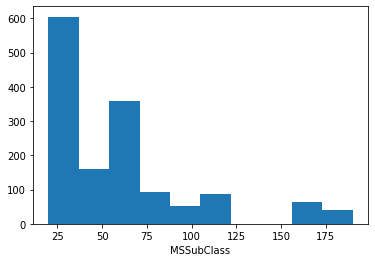

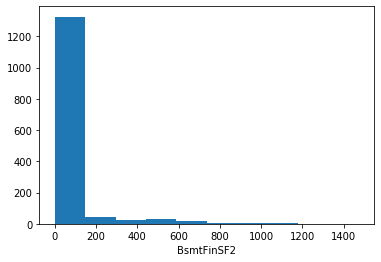

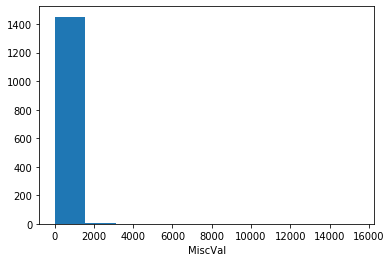

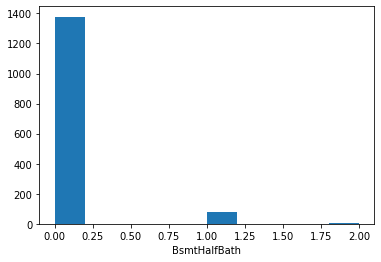

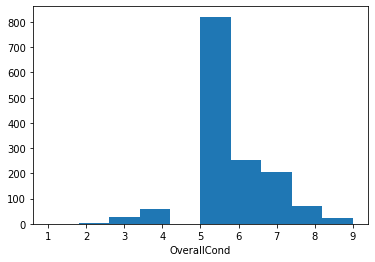

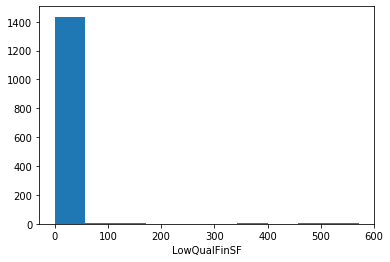

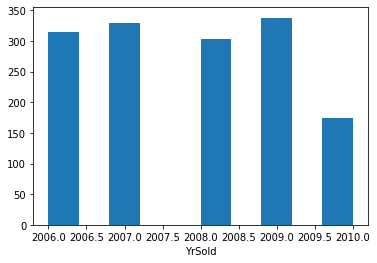

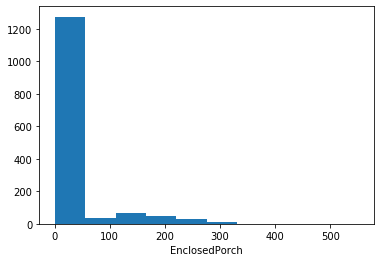

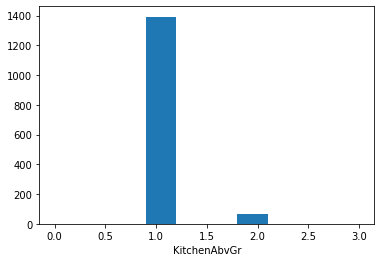

In [0]:
#lets take a closer look at the values, which have a very small correlation with the sales price
'''
MSSubClass
OverallCond
BsmtFinSF2
LowQualFinSF
BsmtHalfBath
KitchenAbvGr
EnclosedPorch
MiscVal
YrSold
'''
uncorr_features = {'MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', 'MiscVal' ,'YrSold'}
num_bins=10
for value in uncorr_features:
  n, bins, patches = plt.hist(train_dataset[value], num_bins)
  plt.xlabel(value)
  plt.show()

We see that MiscVal and LowQualFinSF have a very small correlation with the target and also they have a lot of missing values, so we may remove these features later on

In [0]:
#another way of looking at the postive correlation is having the values in a table:
print(n_correlation['SalePrice'].sort_values(ascending=False).head(10))

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


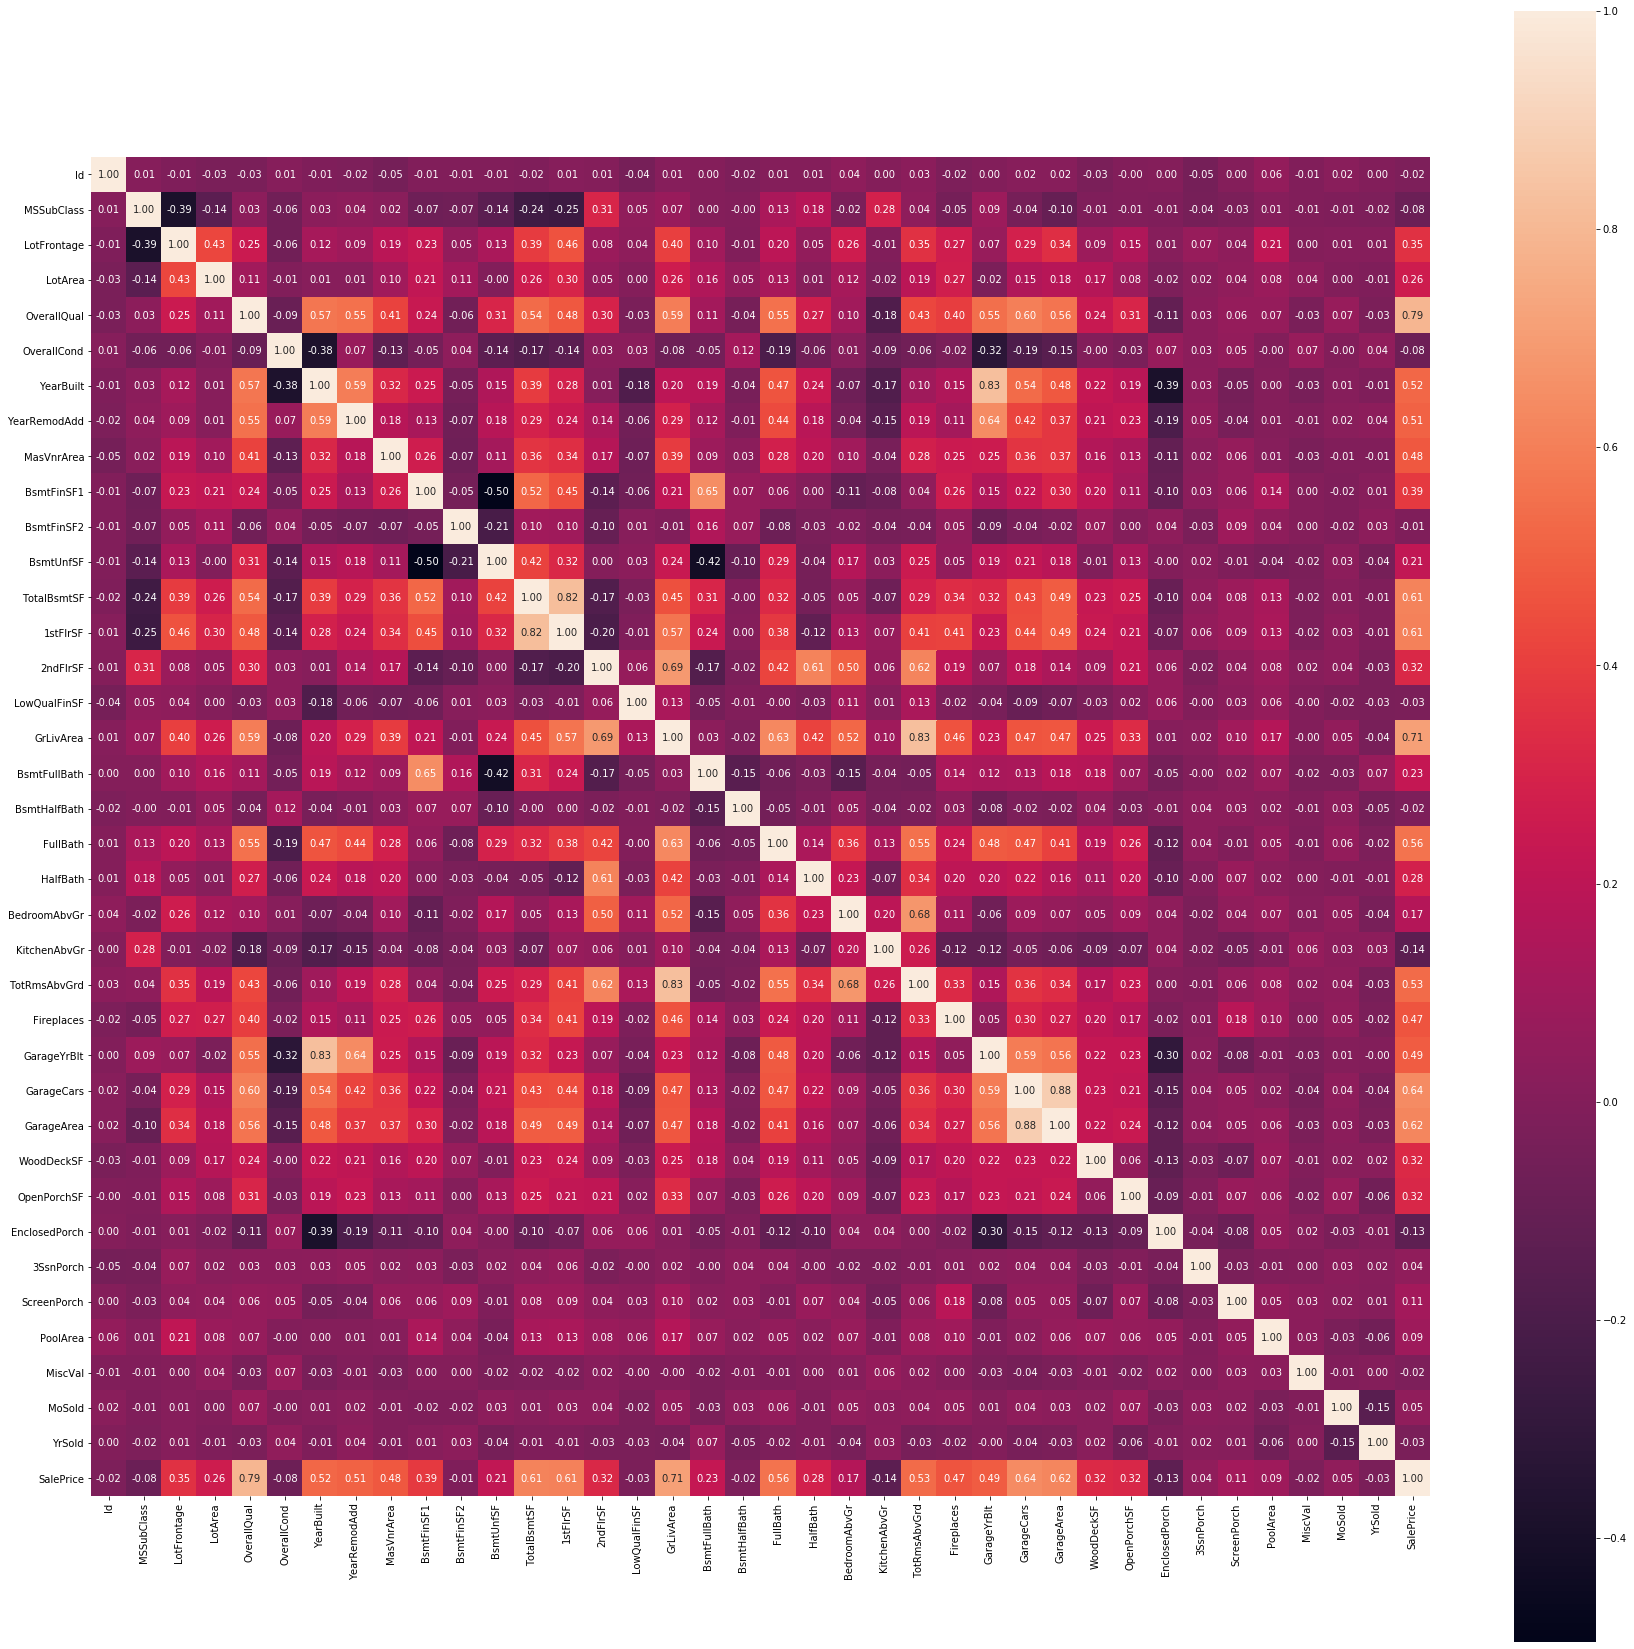

In [0]:
correlation = train_dataset.corr()
plt.subplots(figsize=(30,30))
sns.heatmap(correlation,annot=True,square=True,fmt='.2f')

The heatmap above is a good way to see the correlation between many different variables. Squares that are closer to white show that the variables are correlated. For example, in this heatmap it is possible to see that Garage cars is very correlated with garage area, which makes sense as the bigger the garage the greater the number of cars that could be fit in.

Other variables showing a strong positive correlation is TotalBsmtSf and 1stFlrSqFt

# Catagorical Data

Using Boxplots it is possible to show how SalePrice is affected by catagorical Data.

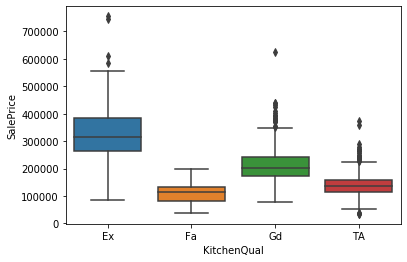

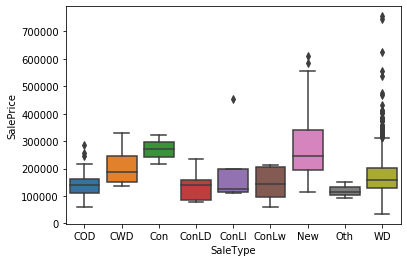

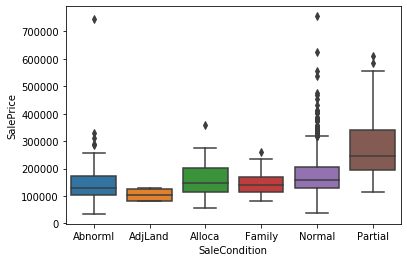

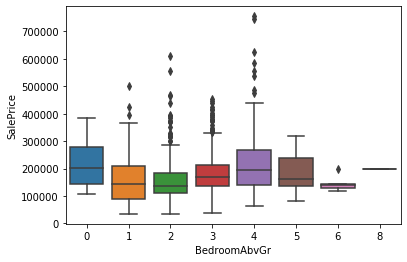

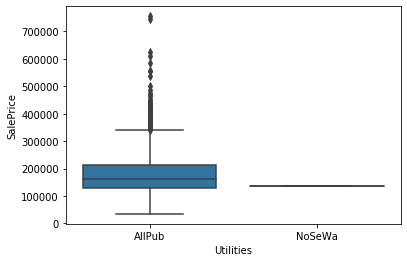

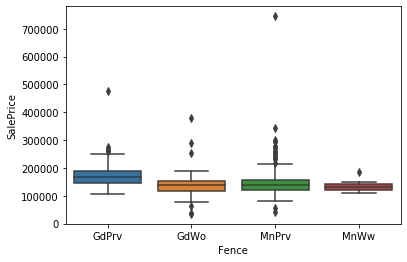

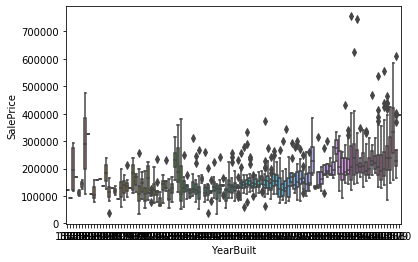

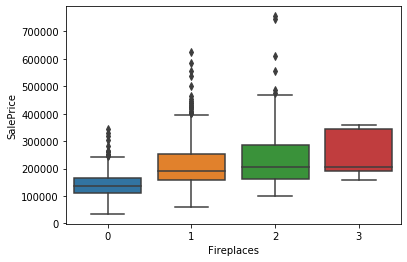

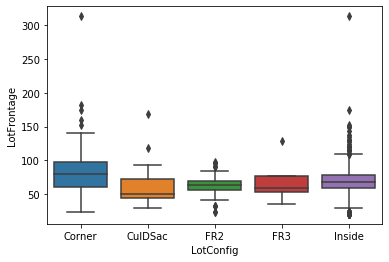

In [0]:
boxplot("KitchenQual", "SalePrice")
boxplot("SaleType", "SalePrice")
boxplot("SaleCondition", "SalePrice")
boxplot("BedroomAbvGr", "SalePrice")
boxplot("Utilities")
boxplot("Fence")
boxplot("YearBuilt")
boxplot("Fireplaces")
boxplot("LotConfig","LotFrontage")



In [0]:
train_ID = train_dataset['Id']
test_ID = test_dataset['Id']


# Now the ID column can be dropped as it is not necessary for the prediction process
train_dataset.drop('Id', axis = 1, inplace = True)
test_dataset.drop('Id', axis = 1, inplace = True)

print("\nThe train dataset size after dropping Id feature is: ", train_dataset.shape)
print("\nThe test dataset size after dropping Id feature is: ", test_dataset.shape)



The train dataset size after dropping Id feature is:  (1460, 80)

The test dataset size after dropping Id feature is:  (1459, 79)


# Cleaning the data:

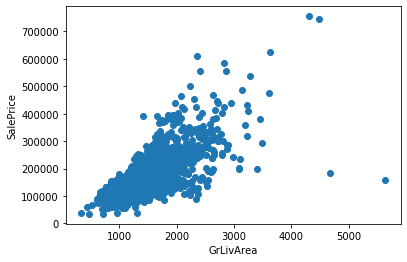

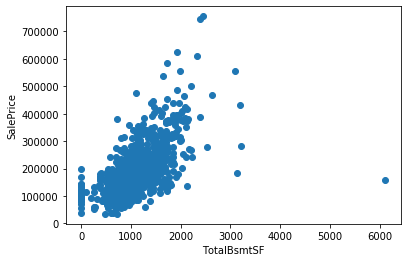

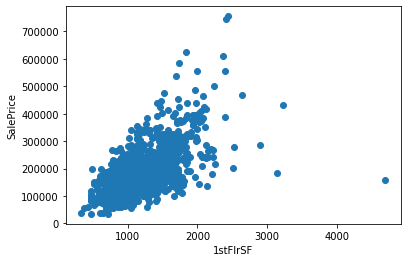

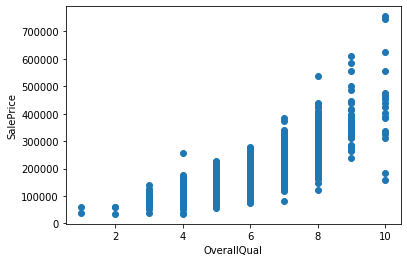

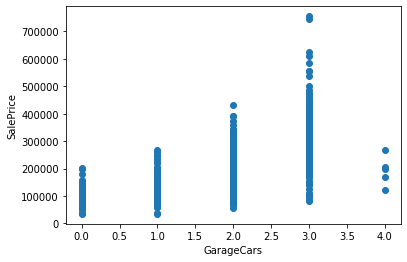

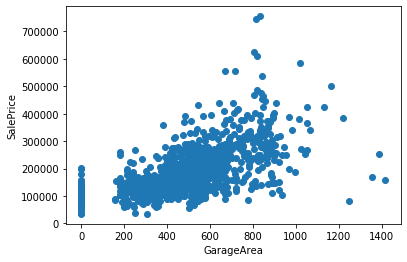

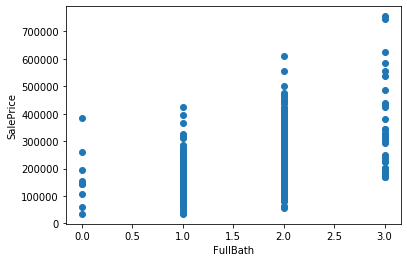

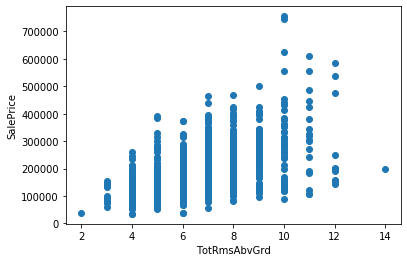

In [0]:
scatter('SalePrice', 'GrLivArea') #done
scatter('SalePrice', 'TotalBsmtSF') #done
scatter('SalePrice', '1stFlrSF') #done
scatter('SalePrice', 'OverallQual') #done
scatter('SalePrice', 'GarageCars') #done
scatter('SalePrice', 'GarageArea') #done
scatter('SalePrice', 'FullBath') #done
scatter('SalePrice', 'TotRmsAbvGrd') #done

From these graphs it can be seen that there is two major outliers, with a large living area with low price. These can be removed from the dataset. It also could be said that the two values with sales price > 700000 could be outliers, however these follow the trend line so should remain

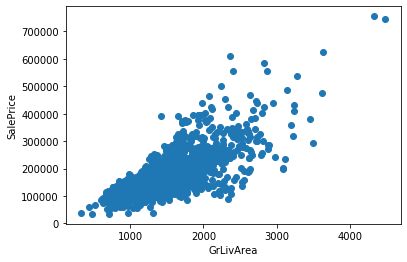

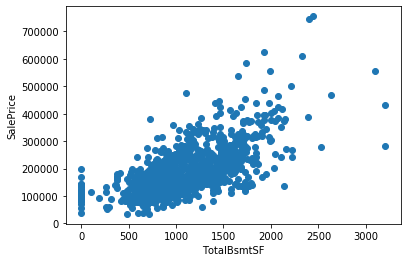

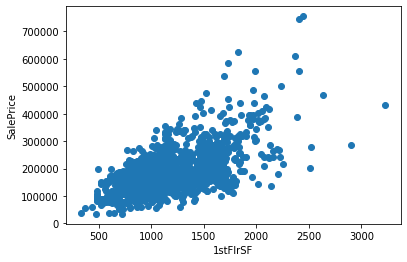

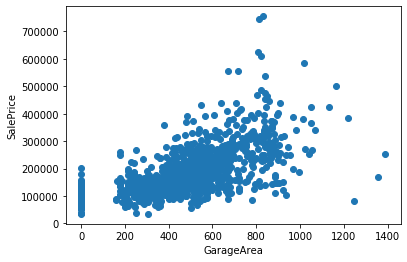

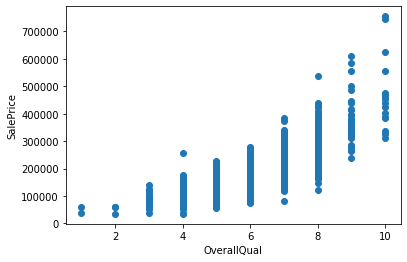

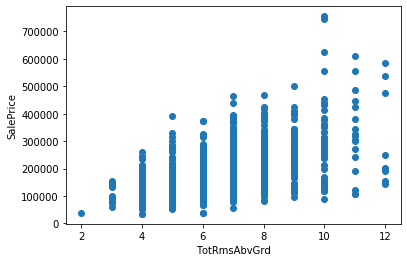

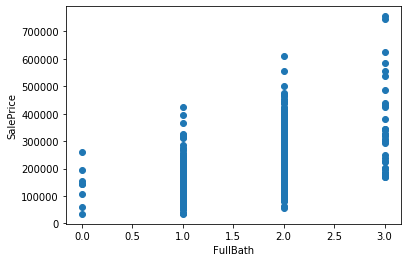

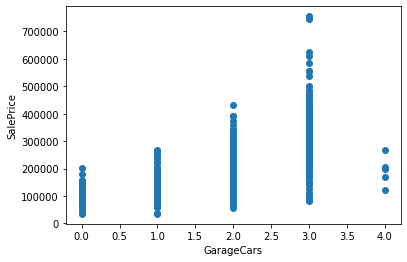

In [0]:
train_dataset = train_dataset.drop(train_dataset[(train_dataset['GrLivArea']>4000) & (train_dataset['SalePrice']<300000)].index)

#train_dataset = train_dataset.drop(train_dataset[(train_dataset['GarageArea']>1200) & (train_dataset['SalePrice']<600000)].index) Removing this made score on kaggle worse.

train_dataset = train_dataset.drop(train_dataset[(train_dataset['OverallQual']==10) & (train_dataset['SalePrice']<200000)].index)
train_dataset = train_dataset.drop(train_dataset[(train_dataset['TotRmsAbvGrd']==14) & (train_dataset['SalePrice']>0)].index)
train_dataset = train_dataset.drop(train_dataset[(train_dataset['FullBath']==0.0) & (train_dataset['SalePrice']>300000)].index)
#train_dataset = train_dataset.drop(train_dataset[(train_dataset['GarageCars']==3.0) & (train_dataset['SalePrice']>700000)].index) Removing this made score on kaggle worse.
# Ensure these have been deleted
scatter('SalePrice', 'GrLivArea')
scatter('SalePrice', 'TotalBsmtSF')
scatter('SalePrice', '1stFlrSF')
scatter('SalePrice','GarageArea')
scatter('SalePrice','OverallQual')
scatter('SalePrice','TotRmsAbvGrd')
scatter('SalePrice','FullBath')
scatter('SalePrice','GarageCars')


Earlier we saw that the target variable (y) is positively skewed. Linear models prefer to work with normally distributed data, therefore we must transform it. A log function is a useful way to transform positively skewed data 

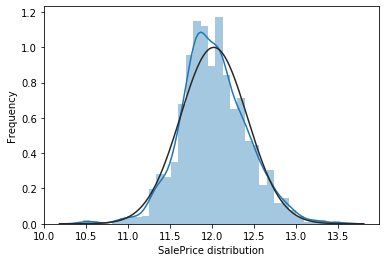

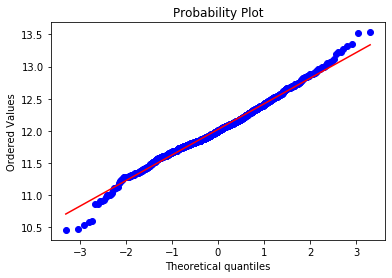

In [0]:
train_dataset["SalePrice"] = np.log1p(train_dataset["SalePrice"])

#Check to see if the data is now normally skwewed
sns.distplot(train_dataset['SalePrice'], fit=norm);
plt.ylabel('Frequency')
plt.xlabel('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_dataset['SalePrice'], plot=plt)
plt.show()

The data is now closer to being normally distributed, which will help with predicting house prices values later. However, we must remember to reverse this operation later, using the inverse of log1p, expm1

#Joining the data set

Before begining the data cleanup process, it is a good idea to concatenate the two datasets (test and train) so that any operations applied is applied to the entire dataset.

In [0]:
y_train = train_dataset.SalePrice.values

combined_data = pd.concat((train_dataset, test_dataset), keys=["train", "test"], sort=False)
combined_data.drop(['SalePrice'], axis=1, inplace = True)
print("combined_data size is:", combined_data.shape)

combined_data size is: (2915, 79)


#Dealing with missing values

In [0]:
#Determines the missing values from the test dataset
# and shows which columns have at least one missing value.
missing_data = missing(combined_data)
missing_data.head(100)

missing_train = missing(train_dataset)
missing_train.head(100)

,Total,Percent
PoolQC,1450,99.59
MiscFeature,1402,96.29
Alley,1366,93.82
Fence,1175,80.70
FireplaceQu,689,47.32
LotFrontage,259,17.79
GarageType,80,5.49
GarageCond,80,5.49
GarageFinish,80,5.49
GarageQual,80,5.49


In [0]:
# Columns in noneFills are columns where the data description says that a missing value is equal to None/the item not existing.
# Therefore anything in these catagories can be filled with the value of none.
noneFills = ["GarageType", "GarageFinish", "GarageQual", "GarageCond",'BsmtQual', 
             'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType', 'MSSubClass' ]

for column in noneFills:
    combined_data[column].fillna("None", inplace=True)



# Zero fills are where the data description describes missing data as the item not existing, therefore it can be 0
# e.g. garageyrblt = 0 will mean no garage
zeroFills = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 
             'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 
             'BsmtHalfBath', 'MasVnrArea']

for column in zeroFills:
    combined_data[column].fillna(0, inplace=True)




# ideas on what value to replace na with from https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
# If the data is missing, it can be filled with the value for the most common mszoning.
combined_data["MSZoning"] = combined_data["MSZoning"].fillna(combined_data['MSZoning'].mode()[0])


# Assumes NA value for Utilities means has all utilities (AllPub)
combined_data["Utilities"] = combined_data["Utilities"].fillna("AllPub")

# Assumes that if no defects are noticed with the house that its functionality
# must be typical
combined_data["Functional"] = combined_data["Functional"].fillna("Typ")

#only one item of data is missing a value for electrical. we can assume therefore it has the most common value, of SBrKr
combined_data["Electrical"] = combined_data["Electrical"].fillna(combined_data['Electrical'].mode()[0])


#only one item of data is missing a value for electrical. we can assume therefore it has the most common value, of SBrKr
combined_data["KitchenQual"] = combined_data["KitchenQual"].fillna(combined_data['KitchenQual'].mode()[0])

combined_data["Exterior1st"] = combined_data["Exterior1st"].fillna(combined_data['Exterior1st'].mode()[0])
combined_data["Exterior2nd"] = combined_data["Exterior2nd"].fillna(combined_data['Exterior2nd'].mode()[0])



combined_data["SaleType"] = combined_data["SaleType"].fillna(combined_data['SaleType'].mode()[0])







#Removing skewness from all other features

In [0]:
#The following idea from: https://www.kaggle.com/phylake1337/housing-prices

features = [ 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'MSSubClass',
       '1stFlrSF', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF',
       '2ndFlrSF', 'Fireplaces', 'TotRmsAbvGrd', 'HalfBath', 'TotalBsmtSF',
       'BsmtFullBath', 'OverallCond', 'YearBuilt', 'GarageYrBlt']


for i in features:
  combined_data[i] = boxcox1p(combined_data[i], boxcox_normmax(combined_data[i] + 1))

#Dropping values with high missing value percentages

In [0]:
combined_data.drop('PoolQC', axis=1, inplace=True)
combined_data.drop('MiscFeature', axis=1, inplace=True)
combined_data.drop('Alley', axis=1, inplace=True)
combined_data.drop('Fence', axis=1, inplace=True)
combined_data.drop('FireplaceQu', axis=1, inplace=True)
combined_data.drop('LotFrontage', axis=1, inplace=True)
combined_data.drop('LowQualFinSF', axis=1, inplace=True)
combined_data.drop('MiscVal', axis=1, inplace=True)


In [0]:
#Determines the missing values from the test dataset
# and shows which columns have at least one missing value.
missing = missing(combined_data)
missing_data.head(100)

,Total,Percent
PoolQC,2906,99.69
MiscFeature,2810,96.40
Alley,2718,93.24
Fence,2344,80.41
FireplaceQu,1419,48.68
LotFrontage,486,16.67
GarageCond,158,5.42
GarageQual,158,5.42
GarageYrBlt,158,5.42
GarageFinish,158,5.42


# Feature Engeneering


In [0]:
#creating new features according to a kaggle notebook: https://www.kaggle.com/amiiiney/price-prediction-top-15-regularization-stacking

combined_data['TotalArea'] = combined_data['TotalBsmtSF'] + combined_data['1stFlrSF'] + combined_data['2ndFlrSF'] #+ combined_data['GrLivArea'] + combined_data['GarageArea']
combined_data['Bathrooms'] = combined_data['BsmtFullBath'] + (combined_data['BsmtHalfBath'] * 0.5) + combined_data['FullBath'] + (combined_data['HalfBath'] * 0.5)

#Dropping unnecessary features

The following features could be dropped.
These features were tested, and ensure that they did not effect the CV score of the model.


In [0]:
combined_data['MSSubClass'] = combined_data['MSSubClass'].astype('category')

#These will need to be re-tested, as inplace=True was forgotten so they do not have any affect on the data set atm.


combined_data.drop('YrSold', axis = 1)
combined_data.drop('MoSold', axis = 1)
#combined_data.drop('MiscVal', axis=1, inplace=True) #Helps a small amount
combined_data.drop('GarageYrBlt', axis = 1)#, inplace=True)# Needs to be tested but out of kaggle submissions atm
combined_data.drop('GarageArea', axis = 1)#, inplace=True)# Same as above
combined_data.drop('TotalBsmtSF', axis=1)#, inplace=True)
combined_data.head(100)

MSSubClass MSZoning    LotArea Street LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
train 0     6.517715       RL  14.018756   Pave      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
      1     4.258150       RL  14.310451   Pave      Reg         Lvl    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam   
      2     6.517715       RL  14.677781   Pave      IR1         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
      3     6.882383       RL  14.298447   Pave      IR1         Lvl    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam   
      4     6.517715       RL  15.236854   Pave      IR1         Lvl    AllPub       FR2       Gtl      NoRidge       Norm       Norm     1Fam   
      5     6.102237       RL  15.212504   Pave      IR1         Lvl    AllPub    Inside       Gtl      Mitchel       Norm       Norm     1Fam   
      6     4.258150       RL  14.423802   Pave      Reg         Lvl    AllPub    Inside       Gtl      Somerst       Norm       Norm     1Fam   
      7     6.517715       RL  14.491156   Pave      IR1         Lvl    AllPub    Corner       Gtl       NWAmes       PosN       Norm     1Fam   
      8     6.102237       RM  13.296181   Pave      Reg         Lvl    AllPub    Inside       Gtl      OldTown     Artery       Norm     1Fam   
      9     9.565882       RL  13.725056   Pave      Reg         Lvl    AllPub    Corner       Gtl      BrkSide     Artery     Artery   2fmCon   
      10    4.258150       RL  14.667392   Pave      Reg         Lvl    AllPub    Inside       Gtl       Sawyer       Norm       Norm     1Fam   
      11    6.517715       RL  14.813872   Pave      IR1         Lvl    AllPub    Inside       Gtl      NridgHt       Norm       Norm     1Fam   
      12    4.258150       RL  15.011453   Pave      IR2         Lvl    AllPub    Inside       Gtl       Sawyer       Norm       Norm     1Fam   
      13    4.258150       RL  14.550682   Pave      IR1         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
      14    4.258150       RL  14.608424   Pave      IR1         Lvl    AllPub    Corner       Gtl        NAmes       Norm       Norm     1Fam   
      15    5.869778       RM  13.296181   Pave      Reg         Lvl    AllPub    Corner       Gtl      BrkSide       Norm       Norm     1Fam   
      16    4.258150       RL  14.675914   Pave      IR1         Lvl    AllPub   CulDSac       Gtl        NAmes       Norm       Norm     1Fam   
      17    7.504089       RL  14.580793   Pave      Reg         Lvl    AllPub    Inside       Gtl       Sawyer       Norm       Norm   Duplex   
      18    4.258150       RL  15.140669   Pave      Reg         Lvl    AllPub    Inside       Gtl      SawyerW       RRAe       Norm     1Fam   
      19    4.258150       RL  13.767076   Pave      Reg         Lvl    AllPub    Inside       Gtl        NAmes       Norm       Norm     1Fam   
      20    6.517715       RL  15.229321   Pave      IR1         Lvl    AllPub    Corner       Gtl      NridgHt       Norm       Norm     1Fam   
      21    5.869778       RM  13.733819   Pave      Reg         Bnk    AllPub    Inside       Gtl       IDOTRR       Norm       Norm     1Fam   
      22    4.258150       RL  14.344235   Pave      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
      23    8.258842       RM  12.491475   Pave      Reg         Lvl    AllPub    Inside       Gtl      MeadowV       Norm       Norm   TwnhsE   
      24    4.258150       RL  13.963274   Pave      IR1         Lvl    AllPub    Inside       Gtl       Sawyer       Norm       Norm     1Fam   
      25    4.258150       RL  15.231835   Pave      Reg         Lvl    AllPub    Corner       Gtl      NridgHt       Norm       Norm     1Fam   
      26    4.258150       RL  13.657544   Pave      Reg         Lvl

In [0]:
qual_map = {'Ex' : 5, 'Gd' : 4, 'TA': 3, 'Fa' : 2, 'Po' : 1, "NA" : 0, "None" : 0}

for category in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                 'HeatingQC', 'KitchenQual', 'GarageQual',
                 'GarageCond']:
 combined_data[category] = combined_data[category].map(qual_map)

for category in ['BsmtFinType1', 'BsmtFinType2']:
  combined_data[category] = combined_data[category].map({'None': 0, 'Unf' : 1, 'LwQ': 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ': 5, 'GLQ' :6 })

combined_data['BsmtExposure'].replace({'Na':0, 'No':1, 'Mn':1, 'Av':2, 'Gd':3}, inplace=True)
combined_data['GarageFinish'].replace({'NA' : 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}, inplace=True)
combined_data['LandSlope'] = combined_data['LandSlope'].map({'Sev':0, 'Mod':1, 'Gtl': 2})
combined_data['LotShape'] = combined_data['LotShape'].map({'IR3': 0, 'IR2':1, 'IR1':2, 'Reg': 3})
combined_data['PavedDrive'] = combined_data['PavedDrive'].map({'N': 0, 'P' : 1, 'Y':2})
combined_data['Street'] = combined_data['Street'].map({'Grvl':0, 'Pave':1})
combined_data['CentralAir'] = combined_data['CentralAir'].map({'N':0, 'Y':1})


combined_data.head(100)
    

#One hot encoding

The remaining variables are one-hot encoded. This is where a seperate column for each possible value of the category is created, and a 1 is placed inside the new column if the initial value matches that columns name, otherwise a 0 is inserted. This is useful for catagorical data which has no order

In [0]:
# One-hot encodes all variables
combined_data = pd.get_dummies(combined_data)

combined_data.head()
print(combined_data.shape)

#240 without bug
#242 with bug.

#Splitting the data:

in this section, we split combined data back into train and test datasets, now that all of the operations have been applied consistantly to all of the data.


In [0]:
train_dataset, test_dataset = combined_data.xs("train"), combined_data.xs("test")

X = train_dataset

# Sales prices for the train dataset are held in a variable called
# y_train

#train_X, val_X, train_y, val_y = train_test_split(X,y_train, random_state=0)


#Model Creation and GridSearch Cross Validation

In [0]:
#Create a python dictionary to contain the names and all of the modesl
models = {}

if not test:
  # Create the machine learning model linear regression
  linear =  LinearRegression()
  models["Linear"] = linear

  #Implement Lasso Model
  lasso = Lasso(normalize=True)
  parameters = {'alpha': [1e-4, 1e-3, 1e-2, 1, 5, 10]}

  GSCV = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=10, verbose=1)

  GSCV.fit(X, y_train)

  print(GSCV.best_params_)
  print(GSCV.best_score_)

  lasso_model = GSCV.best_estimator_

  models["Lasso"] = lasso_model
  print(type(GSCV.best_params_['alpha']))

  #Implement Ridge Model
  ridge = Ridge()
  parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1, 5]}
  GSCV = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=10, verbose=1)
  GSCV.fit(X, y_train)

  models["Ridge"] = GSCV.best_estimator_

  #Implement ElasticNet Model
  enet = ElasticNet()
  parameters = {'alpha': [ 1e-4, 1e-3, 5e-3, 1e-2, 1, 5,10 ,20],
                'l1_ratio': np.arange(0.1,1.0,0.1)
                }
  GSCV = GridSearchCV(enet, parameters, scoring='neg_mean_squared_error', cv=10, verbose=1)
  GSCV.fit(X, y_train)

  models["Elastic Net"] = GSCV.best_estimator_
  print((GSCV.best_params_['l1_ratio']))
  print((GSCV.best_params_['alpha']))
else:
  enet = ElasticNet(alpha=0.001, l1_ratio=0.3)
  enet.fit(X, y_train)
  models["Elastic Net"] = enet


#Cross Validation


In [0]:
#implementing cross validation

#the following code was inspired from https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833


#initializing KFold - spliting data into 10 subgroups
cross_val = KFold(n_splits=10, random_state=None, shuffle=True)
#cross_val.get_n_splits(X)

#cross validation score in negative mean squared error using all of the models individually as an estimator
for name, model in models.items():
  print("\n", name)
  scores = -cross_val_score(model, X, y_train, scoring="neg_mean_squared_error", cv=10)
  print("Cross validation scores:", scores)
  print("RMSE CV Scores", np.sqrt(scores).mean())
  print()


# Predict data based on the model which performed the best,  model

elastic = models["Elastic Net"].predict(test_dataset)
#lasso = models["Lasso"].predict(test_dataset)

combined = (elastic * 1.0 )

final_predict = np.expm1(combined)

#Outputing results

In [0]:
#print(final_predict_lasso)
#print(final_predict_en)

print(output_file)
final = pd.DataFrame({'Id': test_ID, 'SalePrice': final_predict})
final.to_csv(output_file, index=False)
final.head(100)

In [0]:
if IN_COLAB and mounted:
     drive.flush_and_unmount()